In [1]:
import pickle
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
from PIL import Image

In [2]:
#upload data from file and split data appropriately
root = '/traffic-signs'
training_file = root + '/train.p'
validation_file = root + '/valid.p'
testing_file = root + '/test.p'

with open(training_file, mode = 'rb') as f:
    train = pickle.load(f)
with open(validation_file, mode = 'rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode = 'rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [3]:
#number of trainging examples
n_train = X_train.shape[0]

#number of validation examples
n_valid = X_valid.shape[0]

#number of testing examples
n_test = X_test.shape[0]

#whats the shape of a traffic sign image
img_shape = X_train.shape[-3:]

#how many unique classes/labels are in the dataset
#create dictionary to store enumerated sign names for testing
num2sign = {}
with open('signnames.csv') as f:
    reader = csv.DictReader(f)
    for row in reader:
        l, name = row['ClassId'], row['SignName']
        num2sign[l] = name

n_labels = len(num2sign)

print("number of training examples: {}".format(n_train))
print("number of testing examples: {}".format(n_test))
print("Image data shape: {}".format(img_shape))
print("number of classes: {}".format(n_labels))

number of training examples: 34799
number of testing examples: 12630
Image data shape: (32, 32, 3)
number of classes: 43


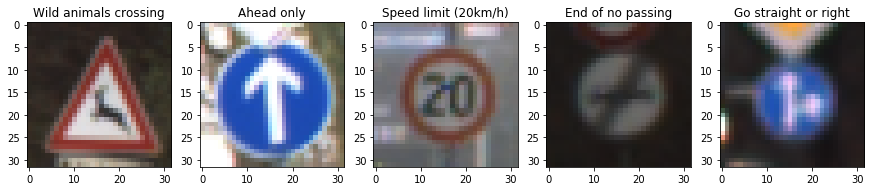

In [4]:
#view data
%matplotlib inline

fig = plt.figure(figsize =(15, 40))

#image 1
ax1 = fig.add_subplot(1,5,1)
plt.imshow(X_train[500])
ax1.set_title(num2sign[str(y_train[500])])

#image 2
ax2 = fig.add_subplot(1,5,2)
plt.imshow(X_train[20000])
ax2.set_title(num2sign[str(y_train[20000])])

#image 3
ax3 = fig.add_subplot(1,5,3)
plt.imshow(X_train[10000])
ax3.set_title(num2sign[str(y_train[10000])])

#image 4
ax4 = fig.add_subplot(1,5,4)
plt.imshow(X_train[3])
ax4.set_title(num2sign[str(y_train[3])])

#image 5
ax5 = fig.add_subplot(1,5,5)
plt.imshow(X_train[1200])
ax5.set_title(num2sign[str(y_train[1200])])

plt.show()

In [5]:
#scale all pixels in images to be between 0 and 1
X_train = X_train.astype(np.float) / 255
X_valid = X_valid.astype(np.float) / 255
X_test = X_test.astype(np.float) / 255

#shuffle all data
X_train, y_train = shuffle(X_train, y_train)

In [6]:
print("new training shape: {}".format(X_train.shape))
print("new valid shape: {}".format(X_valid.shape))
print("new testing shape: {}".format(X_test.shape))

new training shape: (34799, 32, 32, 3)
new valid shape: (4410, 32, 32, 3)
new testing shape: (12630, 32, 32, 3)


In [7]:
#define architecture here

def convnet(x, prob = 1.0):
    
    sigma = 0.1
    mu = 0
    
    #first convlution layer
    conv1_w = tf.Variable(tf.truncated_normal(shape = (5, 5, 3, 32), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(32))
    conv1 = tf.nn.conv2d(x, conv1_w, strides = [1, 1, 1, 1], padding = 'SAME') + conv1_b
    conv1 = tf.maximum(0.2 * conv1, conv1)
    
    #max pooling layer 1
    conv1 = tf.nn.max_pool(conv1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    
    #second convolutional layer
    conv2_w = tf.Variable(tf.truncated_normal(shape = (5, 5, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2 = tf.nn.conv2d(conv1, conv2_w, strides = [1, 1, 1, 1], padding = 'SAME') + conv2_b
    conv1 = tf.maximum(0.2 * conv2, conv2)
    
    #max pooling layer 2
    conv2 = tf.nn.max_pool(conv2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    
    #third convolutional layer
    conv3_w = tf.Variable(tf.truncated_normal(shape = (5, 5, 64, 128), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(128))
    conv3 = tf.nn.conv2d(conv2, conv3_w, strides = [1, 1, 1, 1], padding = 'SAME') + conv3_b
    conv3 = tf.maximum(0.2 * conv3, conv3)
    
    #max pooling layer 3
    conv3 = tf.nn.max_pool(conv3, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    
    #flatten layer 
    fc0 = flatten(conv3)
    
    #fully connected layer #1
    fc1_w = tf.Variable(tf.truncated_normal(shape = (2048, 256), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(256))
    fc1 = tf.matmul(fc0, fc1_w) + fc1_b
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob = prob)
    
    #fully connected layer #2
    fc2_w = tf.Variable(tf.truncated_normal(shape = (256, 128), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(128))
    fc2 = tf.matmul(fc1, fc2_w) + fc2_b
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob = prob)
    
    #output layer
    fc3_w = tf.Variable(tf.truncated_normal(shape = (128, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    
    return logits
    

In [8]:
#initialize and train model here

#define inputs, feature labels and train prob for dropout
X = tf.placeholder(tf.float32, shape = (None, 32, 32, 3))
y = tf.placeholder(tf.int32, shape = (None))
y_one_hot = tf.one_hot(y, 43)
train_prob = tf.placeholder(tf.float32)

learn_rate = 0.001

#make model
logits = convnet(X, prob = train_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = y_one_hot)
loss = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learn_rate)
training_opt = optimizer.minimize(loss)

#make accuracy readout for training
correct = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

top_pred = tf.nn.top_k(tf.nn.softmax(logits), k=5)

#define batches function to get training batches
def batches(x, y, batch_size):
    """generator to get batches during training"""
    
    n_batches = len(x) // batch_size
    x, y = x[:(n_batches * batch_size)], y[:(n_batches * batch_size)]
    
    #get batches
    for ii in range(0, len(x), batch_size):
        batch_x, batch_y = x[ii:ii+batch_size], y[ii:ii+batch_size]
        yield batch_x, batch_y

In [9]:
#training code

#hyperparameters for net
n_epochs = 15
batch_size = 128
iteration = 0
print_every = 100

#used for saving session after training is complete
saver = tf.train.Saver()

#train
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #go through each epoch
    for epoch in range(n_epochs):
        #shuffle at beginning of each epoch
        X_train, y_train = shuffle(X_train, y_train)
        #get batches for training
        for batch_x, batch_y in batches(X_train, y_train, batch_size):
            
            iteration += 1
        
            feed = {X:batch_x, y:batch_y, train_prob: 0.4}
            _ = sess.run(training_opt, feed_dict = feed)
        
            #get and print out validation accuracy
            if iteration % print_every == 0:
            
                val_acc = sess.run(accuracy, feed_dict = {X:X_valid, y:y_valid, train_prob: 1.0})
            
                print("{}/{}".format(epoch+1, n_epochs))
                print("Validation accuracy: {:.2f}%".format(val_acc*100))
    
    print("done")
    print("saving model")
    #save model
    saver.save(sess, 'traffic-signs-classifier')
    print("model saved")

1/15
Validation accuracy: 18.16%
1/15
Validation accuracy: 31.43%
2/15
Validation accuracy: 40.45%
2/15
Validation accuracy: 45.44%
2/15
Validation accuracy: 56.67%
3/15
Validation accuracy: 64.15%
3/15
Validation accuracy: 67.98%
3/15
Validation accuracy: 71.77%
4/15
Validation accuracy: 76.01%
4/15
Validation accuracy: 80.34%
5/15
Validation accuracy: 82.99%
5/15
Validation accuracy: 84.10%
5/15
Validation accuracy: 86.92%
6/15
Validation accuracy: 87.03%
6/15
Validation accuracy: 87.28%
6/15
Validation accuracy: 91.18%
7/15
Validation accuracy: 90.32%
7/15
Validation accuracy: 91.90%
8/15
Validation accuracy: 92.15%
8/15
Validation accuracy: 91.84%
8/15
Validation accuracy: 92.45%
9/15
Validation accuracy: 92.52%
9/15
Validation accuracy: 92.13%
9/15
Validation accuracy: 91.97%
10/15
Validation accuracy: 92.86%
10/15
Validation accuracy: 93.95%
10/15
Validation accuracy: 92.90%
11/15
Validation accuracy: 93.29%
11/15
Validation accuracy: 92.97%
12/15
Validation accuracy: 94.06%
12/1

In [10]:
#test model on test data set
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./traffic-signs-classifier.meta')
    loader.restore(sess, './traffic-signs-classifier')
    
    test_acc = sess.run(accuracy, feed_dict = {X:X_test, y:y_test, train_prob:1.0})
    
    print("testing accuracy: {:.2f}%".format(test_acc*100))
    

INFO:tensorflow:Restoring parameters from ./traffic-signs-classifier
testing accuracy: 93.53%


In [11]:
%matplotlib inline

#load all 5 images
image1 = Image.open('straight_or_right.jpg')
image2 = Image.open('road_work.jpg')
image3 = Image.open('pedestrian.jpg')
image4 = Image.open('animal_crossing.jpg')
image5 = Image.open('70kmh.jpg')

#resize all the images
image1_re = np.array(image1.resize((32, 32), Image.ANTIALIAS))
image2_re = np.array(image2.resize((32, 32), Image.ANTIALIAS))
image3_re = np.array(image3.resize((32, 32), Image.ANTIALIAS))
image4_re = np.array(image4.resize((32, 32), Image.ANTIALIAS))
image5_re = np.array(image5.resize((32, 32), Image.ANTIALIAS))

#normalize pixel values of images
image1_g = image1_re.astype(np.float32) / 255
image2_g = image2_re.astype(np.float32) / 255
image3_g = image3_re.astype(np.float32) / 255
image4_g = image4_re.astype(np.float32) / 255
image5_g = image5_re.astype(np.float32) / 255

#make all images 4 dimensional before feeding to graph
image1_f = np.expand_dims(image1_g, axis = 0)
image2_f = np.expand_dims(image2_g, axis = 0)
image3_f = np.expand_dims(image3_g, axis = 0)
image4_f = np.expand_dims(image4_g, axis = 0)
image5_f = np.expand_dims(image5_g, axis = 0)

labels = [36, 25, 27, 31, 4]

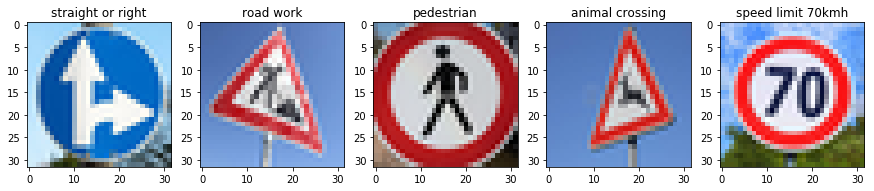

In [13]:
%matplotlib inline
fig = plt.figure(figsize = (15, 40))

rows = 1
cols = 5
image_list = [image1_re, image2_re, image3_re, image4_re, image5_re]
titles = ['straight or right', 'road work', 'pedestrian', 'animal crossing', 'speed limit 70kmh']

fig = plt.figure(figsize = (15, 40))

for i, (img, title) in enumerate(zip(image_list, titles)):
    
    ax = fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    ax.set_title(title)

plt.show()

In [14]:
with tf.Session() as sess:
    new_loader = tf.train.import_meta_graph('./traffic-signs-classifier.meta')
    new_loader.restore(sess, './traffic-signs-classifier')
    
    pred_val = []
    
    #getting predictions for each image and printing them
    pred1 = sess.run(top_pred, feed_dict = {X:image1_f, y:36, train_prob: 1.0})
    print("\nimage 1 looks like {}: {}".format(pred1[1][0][0], num2sign[str(pred1[1][0][0])]))
    print("top 5 predictions for image 1 were: {}".format(pred1[1]))
    print("the correct labels was {}\n".format(labels[0]))
    pred_val.append(pred1[1][0][0])
    
    pred2 = sess.run(top_pred, feed_dict = {X:image2_f, y:25, train_prob: 1.0})
    print("image 2 looks like {}: {}".format(pred2[1][0][0], num2sign[str(pred2[1][0][0])]))
    print("top 5 predictions for image 2 were: {}".format(pred2[1]))
    print("the correct label was {}\n".format(labels[1]))
    pred_val.append(pred2[1][0][0])
    
    pred3 = sess.run(top_pred, feed_dict = {X:image3_f, y:27, train_prob: 1.0})
    print("image 3 looks like {}: {}".format(pred3[1][0][0], num2sign[str(pred3[1][0][0])]))
    print("top 5 predictions for image 3 were: {}".format(pred3[1]))
    print("the correct label was {}\n".format(labels[2]))
    pred_val.append(pred3[1][0][0])
    
    pred4 = sess.run(top_pred, feed_dict = {X:image4_f, y:31, train_prob: 1.0})
    print("image 4 looks like {}: {}".format(pred4[1][0][0], num2sign[str(pred4[1][0][0])]))
    print("top 5 predictions for image 4 were: {}".format(pred4[1]))
    print("the correct label was {}\n".format(labels[3]))
    pred_val.append(pred4[1][0][0])
    
    pred5 = sess.run(top_pred, feed_dict = {X:image5_f, y: 4, train_prob: 1.0})
    print("image 5 looks like {}: {}".format(pred5[1][0][0], num2sign[str(pred5[1][0][0])]))
    print("top 5 predictions for image 5 were: {}".format(pred5[1]))
    print("the correct label was {}\n".format(labels[4]))
    pred_val.append(pred5[1][0][0])
    
    #accuracy
    correct = np.equal(labels, pred_val)
    accuracy = np.mean(correct)
    print("accuracy on images: {:.2f}%".format(accuracy*100))
    
    
    

INFO:tensorflow:Restoring parameters from ./traffic-signs-classifier

image 1 looks like 36: Go straight or right
top 5 predictions for image 1 were: [[36 38 34 32 40]]
the correct labels was 36

image 2 looks like 25: Road work
top 5 predictions for image 2 were: [[25 30 14 31 17]]
the correct label was 25

image 3 looks like 4: Speed limit (70km/h)
top 5 predictions for image 3 were: [[ 4 33 39  8 18]]
the correct label was 27

image 4 looks like 20: Dangerous curve to the right
top 5 predictions for image 4 were: [[20 30 17 28 25]]
the correct label was 31

image 5 looks like 1: Speed limit (30km/h)
top 5 predictions for image 5 were: [[ 1  0  4  2 15]]
the correct label was 4

accuracy on images: 40.00%
